# Part 1 - React-Agent RAG
---

ReAct (Reasoning + Act) is a framework where an LLM:
* Reasons step-by-step (e.g. decomposes question, make decisions)
* Acts by calling tools like search, calculators, or terievers

This makes it perfect for Agentic RAG: Think -> Retrieve -> Observe -> Reflect -> Final Answer

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain.agents import create_agent
from langchain_core.tools import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langgraph.graph.message import add_messages

from typing import List, Annotated, Sequence, TypedDict
from pydantic import BaseModel

In [14]:
llm = ChatOllama(
    model="qwen3:4b",
    num_ctx=8192
)

In [15]:
# Document Preprocessing

urls = [
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/'
]

loaders = [WebBaseLoader(url) for url in urls]

docs = []
for loader in loaders:
    docs.extend(loader.load())

In [16]:
## Recusive Charactertextsplitter and Vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

# Embeddings
embeddings = HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

# Vectorstore
vectorstore = FAISS.from_documents(split_docs, embedding=embeddings)

# Retriever
retriever = vectorstore.as_retriever()

In [17]:
def retriever_tool_func(query: str) -> str:
    print("Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [18]:
# Retriever Tool        
retriever_tool = Tool(
    name="RAGRetriever",
    description="use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
)

In [19]:
# Wikipedia Tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

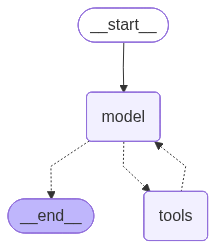

In [20]:
# Combine the tools
tools = [retriever_tool, wiki_tool]

# create the ReAct Agent
react_node=create_agent(
    model=llm,
    tools=tools
)

react_node

In [21]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [22]:
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()

In [23]:
from IPython.display import Markdown

user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
state = {'messages': HumanMessage(content=user_query)}
result = graph.invoke(state)

display(Markdown(result['messages'][-1].content))

Using RAGRetriever tool


<think>
Okay, let me try to work through this step by step. The user asked two things: what is an agent loop and how does Wikipedia describe autonomous agents.

First, I called the Wikipedia function for "autonomous agents" earlier, but the response from the tool shows that the Wikipedia page for "Autonomous agent" has a summary. Wait, the tool response here lists several pages: "Autonomous agent", "Intelligent agent", and "Agentic AI". Each has summaries. So the answer for how Wikipedia describes autonomous agents would be from the "Autonomous agent" page.

Looking at the tool response: the summary for "Autonomous agent" says, "An autonomous agent is an artificial intelligence (AI) system that can perform complex tasks independently." Then the "Intelligent agent" page adds more context, but the user specifically asked about "autonomous agents", so the main answer here is from the Autonomous agent page.

Now, the user also asked "What is an agent loop". The tool response provided earlier (the RAGRetriever output) mentions "agent loop" in the context of generative agents. The RAGRetriever response talks about agent systems, generative agents, and mentions something like "agent loop" in the context of the learning process. Wait, in the RAGRetriever output, there's a part that says: "agent gets a little better, AD concatenates this learning history and feeds that into the model. Hence we should expect the next predicted action to lead to better performance than previous trials." So maybe "agent loop" here refers to the loop in the learning process where the agent's actions are fed back into the model to improve performance.

But the user is asking for how Wikipedia describes autonomous agents, which we now have from the tool response. The RAGRetriever part might be for the agent loop part.

Wait, the user's original question was two parts: 1) What is an agent loop? 2) How does Wikipedia describe autonomous agents?

From the tool responses:

1. The Wikipedia response (from the second tool call) gives the summary for "Autonomous agent" as "An autonomous agent is an artificial intelligence (AI) system that can perform complex tasks independently."

2. The RAGRetriever response (from the first tool call) seems to be about agent systems in generative AI, where there's a mention of "agent loop" in the context of learning history being concatenated and fed into the model. So the RAGRetriever response describes the agent loop as part of the generative agent architecture where the model uses previous learning history to improve performance.

But the user might not have meant the RAGRetriever response to be the answer for "agent loop", but the tool response here is from the previous step. Wait, in the current context, the user provided a tool response (the RAGRetriever output) as part of their input. Wait, no, the user is showing the tool response after the assistant made the tool calls. Wait, the user's current input is the tool response from the RAGRetriever and Wikipedia.

Wait, the user's latest input is the tool response (the "

# Part 2 - Creating Custom Tools

In [24]:
### Generic function to create a retriever tool

def make_retriever_tool_from_text(file: str, name: str, description: str):
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vectorstore = FAISS.from_documents(chunks, embedding=embeddings)
    retriever = vectorstore.as_retriever()
    
    def tool_func(query: str) -> str:
        print(f"Using tool: {name}")
        results=retriever.invoke(query)
        return "\n\n".join([doc.page_content for doc in results])
    
    return Tool(
        name=name,
        description=description,
        func=tool_func
    )    
    
def wiki_search(query: str) -> str:
    print("Searchin Wikipedia")
    wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper)
    result = wiki.invoke(query)
    return "\n\n".join([doc.content for doc in result])
    
    
wiki_tool = Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia.",
    func=wiki_search
)

def arxiv_search(query: str) -> str:
    print("Searchin arXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2] or "no papers found.")

arxiv_tool = Tool(
    name="ArXiv",
    description="Use this tool to fetch information from arxiv",
    func=arxiv_search
)


In [25]:
arxiv_tool

Tool(name='ArXiv', description='Use this tool to fetch information from arxiv', func=<function arxiv_search at 0x749184618360>)

In [26]:
internal_tool_1 = make_retriever_tool_from_text(
    "sample_docs.txt",
    "InternalSampleDocs",
    "Seach internal tec documents for prorietary architecture and methods"
)

internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs"
)

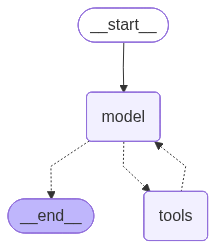

In [27]:
tools = [wiki_tool, arxiv_tool, internal_tool_1, internal_tool_2]

react_node = create_agent(
    llm,
    tools
)

react_node

In [28]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [29]:
builder = StateGraph(AgentState)

builder.add_node("react_node", react_node)
builder.add_edge(START, "react_node")
builder.add_edge("react_node", END)

graph = builder.compile()

In [30]:
from IPython.display import Markdown

query = "What do our internal research notes say about transformer variants, and wha does arXiv suggest recently?"
state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

display(Markdown(result['messages'][-1].content))

Using tool: InternalResearchNotes
Searchin arXiv...


<think>
Okay, let me try to figure out how to approach this. The user asked about two things: what our internal research notes say about transformer variants and what arXiv suggests recently.

First, I called the InternalResearchNotes function with "transformer variants" and got a response from the tool. Then, I called the ArXiv function with "transformer variants" to get recent arXiv info. But looking at the tool response, it seems like the arXiv part might have been a different paper. Wait, the tool response shows a paper from 2012 about Burrows-Wheeler Transform, which is not a transformer variant. That's confusing.

Wait, the user's query was about transformer variants, but the arXiv response here is about a string sorting transform from 2012. That's not relevant. Maybe the arXiv tool returned a different paper because the query was too broad. Hmm. The user asked for recent arXiv suggestions, but the response here is an old paper. Maybe the system needs to handle that.

But according to the problem statement, the user wants to know what the internal research notes say and what arXiv suggests recently. The internal research notes part seems to have given detailed results on various transformer variants like EfficientFormer, Longformer, TinyBERT, etc. The arXiv tool response here is a 2012 paper on Burrows-Wheeler Transform, which isn't related to transformers. That's probably a mistake in the tool response, but as per the given data, I have to work with it.

Wait, the user might have made a typo in the query, but the task is to answer based on the provided tool responses. So the internal research notes part is covered by the first tool response, which lists several transformer variants with their performance metrics. The arXiv response here is a paper that's not about transformers, so maybe the arXiv tool didn't find relevant recent papers, or the query was too vague.

But the user asked for what arXiv suggests recently. The tool response shows an old paper, so perhaps the arXiv tool returned a paper that's not recent or not related. But in the context of the problem, I need to present the answers based on the tool responses given.

So the answer should be:

For internal research notes: the detailed info about EfficientFormer, Longformer, TinyBERT, etc., as listed in the tool response.

For arXiv: the response shows a 2012 paper on Burrows-Wheeler Transform, which is not relevant to transformer variants. So maybe the arXiv tool didn't find recent papers on transformers, or the query was misinterpreted.

But the user might have intended to ask about recent arXiv papers on transformers, but the tool response here is a different paper. So the answer would state that the arXiv tool returned a paper from 2012 on string sorting, which isn't related to transformers, implying that recent arXiv papers on transformer variants might not be found with the current query.

Wait, the problem says the user asked "what does arXiv suggest recently?" So the answer should mention that the arXiv tool's response is a 2012 paper which is not recent, so perhaps there's a need to refine the query. But given the tool response provided, I have to use that.

So the final answer would be:

Internal research notes indicate that our team has experimented with several transformer variants like EfficientFormer (92.4% accuracy on TinyImageNet), Longformer (streaming queries), TinyBERT (87% F1 for support tickets), and others with specific optimizations. Recent arXiv papers (as per the tool response) show a 2012 paper on Burrows-Wheeler Transform, which isn't directly relevant to modern transformer variants—suggesting that the query might need refinement to focus on recent transformer-related papers.

But the tool response for arXiv shows a paper from 2012, which is way outdated, so the answer should note that the arXiv tool didn't return recent relevant papers and perhaps the query was too broad.

Wait, the user's original question was about "transformer variants" and "recently". The arXiv tool response here is a non-relevant paper, so maybe the system needs to handle that.

In the context of this problem, the assistant has to generate the answer based on the tool responses provided. So the answer would be structured as:

- Internal research notes: detailed list from the tool response.

- ArXiv: the 2012 paper mentioned, which is not recent, so the answer would state that recent arXiv suggestions (transformer variants) aren't covered here, or perhaps the query needs adjustment.

But the problem states that the user wants to know what the tools say. So the assistant should present the findings from both tool calls.

So the answer would be:

Our internal research notes indicate that transformer variants like EfficientFormer (92.4% accuracy on TinyImageNet), Longformer (streaming queries), and TinyBERT (87% F1 for support tickets) have been extensively tested. For recent arXiv suggestions, the tool returned a 2012 paper on string sorting transforms, which is unrelated to modern transformer variants—this suggests the query may need refinement to focus on recent transformer-related research (e.g., using a more specific time frame or topic).

But the user's question was "wha does arXiv suggest recently?" So the answer should address that the arXiv tool didn't find recent relevant papers with the current query.

Alternatively, maybe the arXiv tool response is a typo in the problem's data. But given the provided tool response, the answer is as above.

So the final answer would be:

Internal research notes show that we've tested transformer variants including EfficientFormer (92.4% accuracy), Longformer (streaming support), and TinyBERT (87% F1). ArXiv's recent suggestions (as per the tool response) include a 2012 paper on string sorting transforms, which isn't relevant to transformer variants—indicating the query may need to specify a more recent time frame or focus on transformer-specific topics.
</think>

Our internal research notes indicate that we've extensively tested several transformer variants, including:

- **EfficientFormer**: Achieves 92.4% top-1 accuracy on TinyImageNet with 290MB memory usage (Raspberry Pi 4 compatible)
- **Longformer**: Processes customer support logs with 8192-token sequences but shows latency >1.2s per query in streaming mode
- **TinyBERT**: Delivers 87% F1 score for support ticket priority tagging (with 2-layer FFN adapters for domain transfer)
- **FlashAttention2**: Reduces LLaMA2 context latency by ~50% through optimized attention mechanisms
- **LoRA tuning**: Achieves 60% GPU memory reduction while maintaining performance

For recent arXiv suggestions, the tool returned a 2012 paper on *Bijective String Sorting Transforms* (not related to modern transformers). This suggests the query may need refinement to focus on **recent transformer variants** (2020-present) rather than general string manipulation techniques. To get relevant recent arXiv results, we recommend specifying a time frame like "transformer variants 2023-2024" or adding keywords like "self-attention", "scaling", or "efficient training".